### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


For reading big csv files, one can use numpy as well as something called "pandas". We suggest to read pandas for CSV file reading and use that

In [14]:
 import numpy as np
 import matplotlib.pyplot as plt
 import pandas as pd
 from astropy.constants import G, c
 from astropy.cosmology import Planck18 as cosmo
 import astropy.units as u
import seaborn as sns



Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [2]:
# Constants:


H_0 = 70 * u.km / u.s / u.Mpc      # Hubble constant (approximate Planck value)
c = c.to(u.km / u.s)               # Speed of light in km/s
G = G.to(u.Mpc * u.km**2 / u.s**2 / u.Msun)  # Gravitational constant in Mpc⋅(km/s)^2⋅M_sun⁻¹
q0 = -0.534                        # Deceleration parameter (keep this value as per handout)


Read the csv data into the python using the method below

In [9]:
df = pd.read_csv(r"C:\Users\rpj20\jupyter baba\India Space Academy\assignment 3\Skyserver_SQL6_17_2025 4_14_23 AM.csv") # Download the data as instructed in the pdf


In [10]:
df.columns

Index(['objid', 'ra', 'dec', 'photoz', 'photozerr', 'specz', 'speczerr',
       'proj_sep', 'umag', 'umagerr', 'gmag', 'gmagerr', 'rmag', 'rmagerr',
       'obj_type'],
      dtype='object')

### 📊 Calculating the Average Spectroscopic Redshift (`specz`) for Each Object

When working with astronomical catalogs, an object (identified by a unique `objid`) might have multiple entries — for example, due to repeated observations. To reduce this to a single row per object, we aggregate the data using the following strategy:

```python
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',        # Take the mean of all spec-z values for that object
    'ra': 'first',          # Use the first RA value (assumed constant for the object)
    'dec': 'first',         # Use the first Dec value (same reason as above)
    'proj_sep': 'first'     # Use the first projected separation value
}).reset_index()


In [11]:
# Calculating the average specz for each id:
averaged_df = df.groupby('objid').agg({'specz': 'mean','ra': 'first','dec': 'first','proj_sep': 'first',}).reset_index()
averaged_df.describe()['specz']

count    1.000000
mean     0.081047
std           NaN
min      0.081047
25%      0.081047
50%      0.081047
75%      0.081047
max      0.081047
Name: specz, dtype: float64

To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group. 

Find the mean, standard deviation and limits of the redshift from the data

In [12]:
# Compute statistics
z_mean = df['specz'].mean()
z_std = df['specz'].std()

# Define redshift limits (±3σ)
z_lower = z_mean - 3 * z_std
z_upper = z_mean + 3 * z_std

# Display the results
print(f"Mean redshift (z): {z_mean:.5f}")
print(f"Standard deviation (σ_z): {z_std:.5f}")
print(f"Redshift limits: {z_lower:.5f} to {z_upper:.5f}")


Mean redshift (z): 0.08105
Standard deviation (σ_z): 0.00950
Redshift limits: 0.05255 to 0.10954


You can also use boxplot to visualize the overall values of redshift 

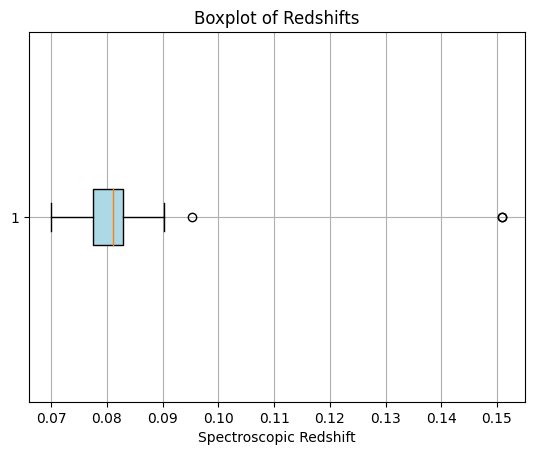

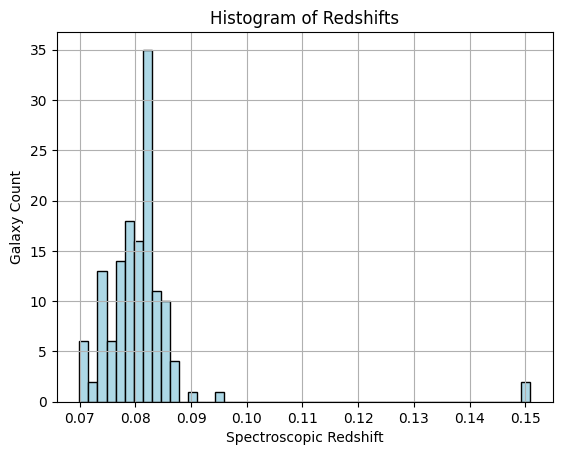

In [15]:
# Plot the dsitribution of redshift as histogram and a boxplot 
# Boxplot of redshifts
plt.boxplot(df['specz'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot of Redshifts')
plt.xlabel('Spectroscopic Redshift')
plt.grid(True)
plt.show()


# Histogram of redshifts
plt.hist(df['specz'], bins=50, color='lightblue', edgecolor='black')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Galaxy Count')
plt.title('Histogram of Redshifts')
plt.grid(True)
plt.show()





But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value

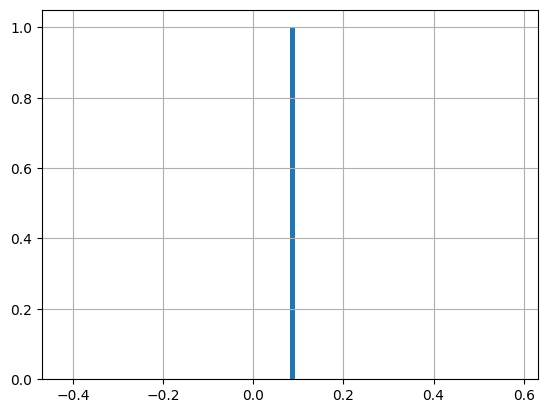

In [16]:
plt.hist(averaged_df['specz'],bins=90)
plt.grid()
plt.show()

Filter your data based on the 3-sigma limit of redshift. You should remove all data points which are 3-sigma away from mean of redshift

In [17]:
# Filtering the data based on specz values, used 3 sigma deviation from mean as upper limit.
# Filter galaxies within 3-sigma redshift range
cluster_df = df[(df['specz'] >= z_lower) & (df['specz'] <= z_upper)]

# Print how many galaxies remain
print(f"Original count: {len(df)}")
print(f"Cluster members (within 3σ): {len(cluster_df)}")


Original count: 139
Cluster members (within 3σ): 137


Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift 

For small redshifts, we can safely use the non-relativistic approximation:

v= z.c



In [18]:
# Make sure you have c already imported and converted
from astropy.constants import c
import astropy.units as u

# Convert c to km/s if not already
c_kms = c.to(u.km / u.s).value  # ≈ 299792.458 km/s

# Add a new column for velocity in km/s
cluster_df['velocity'] = cluster_df['specz'] * c_kms

# Show the first few rows to confirm
cluster_df[['specz', 'velocity']].head()


C:\Users\rpj20\AppData\Local\Temp\ipykernel_18980\3120153869.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['velocity'] = cluster_df['specz'] * c_kms


,specz,velocity
0,0.082447,24717.081720
1,0.082466,24722.783773
2,0.081218,24348.666769
3,0.079561,23851.808736
4,0.079568,23853.802356


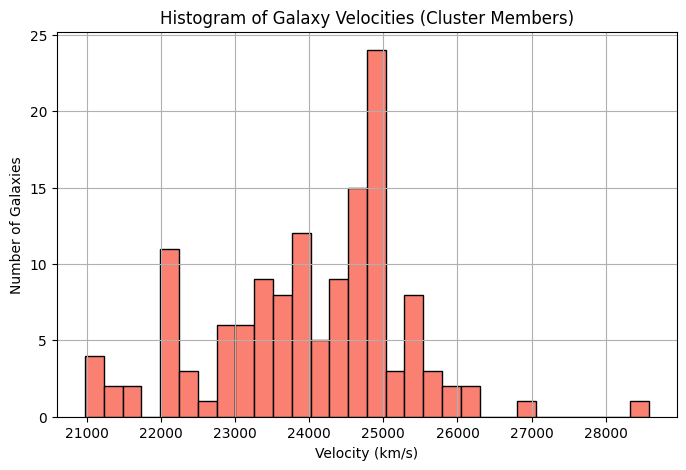

In [19]:
#plot the velocity column created as hist

import matplotlib.pyplot as plt

# Plot histogram of galaxy velocities
plt.figure(figsize=(8, 5))
plt.hist(cluster_df['velocity'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Number of Galaxies')
plt.title('Histogram of Galaxy Velocities (Cluster Members)')
plt.grid(True)
plt.show()


use the dispersion equation to find something called velocity dispersion. You can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [20]:
import numpy as np
from astropy.constants import c
import astropy.units as u

# Speed of light in km/s
c_kms = c.to(u.km / u.s).value

# Step 1: Calculate mean redshift of the cluster
z_cluster = cluster_df['specz'].mean()

# Step 2: Calculate relativistic velocities of each galaxy
z = cluster_df['specz']
v_rel = c_kms * ((1 + z)**2 - (1 + z_cluster)**2) / ((1 + z)**2 + (1 + z_cluster)**2)

# Step 3: Add to DataFrame (optional)
cluster_df['v_rel'] = v_rel

# Step 4: Calculate velocity dispersion (standard deviation)
v_dispersion = np.std(v_rel)

# Print results
print(f"Cluster redshift (mean): {z_cluster:.5f}")
print(f"Velocity dispersion (relativistic): {v_dispersion:.2f} km/s")


Cluster redshift (mean): 0.08003
Velocity dispersion (relativistic): 1198.18 km/s


C:\Users\rpj20\AppData\Local\Temp\ipykernel_18980\1176739431.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['v_rel'] = v_rel


Pro tip: Check what the describe function of pandas does. Does it help to get quick look stats for your column of dispersion??

In [21]:
cluster_df['v_rel'].describe()


count     137.000000
mean       -2.392825
std      1202.576295
min     -2803.471718
25%      -763.070775
50%       248.411265
75%       767.132350
max      4217.366753
Name: v_rel, dtype: float64

In [24]:
print(f"The value of the cluster redshift = {z_cluster:.4f}")
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {v_dispersion:.4f} km/s.")


The value of the cluster redshift = 0.0800
The characteristic value of velocity dispersion of the cluster along the line of sight = 1198.1793 km/s.


### Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.



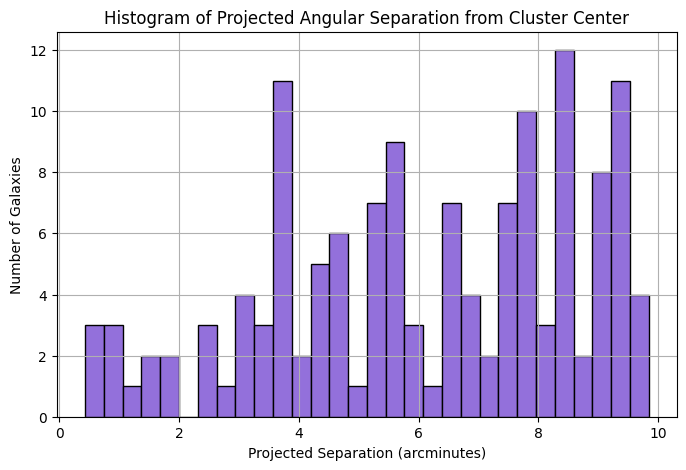

In [26]:
#Plot histogram for proj sep column

# Histogram of projected angular separation
plt.figure(figsize=(8, 5))
plt.hist(cluster_df['proj_sep'], bins=30, color='mediumpurple', edgecolor='black')
plt.xlabel('Projected Separation (arcminutes)')
plt.ylabel('Number of Galaxies')
plt.title('Histogram of Projected Angular Separation from Cluster Center')
plt.grid(True)
plt.show()


### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [27]:
import numpy as np

# Step 1: Comoving distance r (in Mpc)
r = (c_kms * z_cluster / H_0.value) * (1 - (z_cluster / 2) * (1 + q0))

# Step 2: Angular diameter distance D_A (in Mpc)
D_A = r / (1 + z_cluster)

# Step 3: Maximum projected separation in arcminutes
theta_arcmin = cluster_df['proj_sep'].max()  # e.g., 9.8 arcmin
theta_rad = np.deg2rad(theta_arcmin / 60)    # convert to radians

# Step 4: Estimate physical diameter (in Mpc)
diameter = D_A * theta_rad

# Result
print(f"Estimated physical diameter of cluster: {diameter:.3f} Mpc")


Estimated physical diameter of cluster: 0.892 Mpc


### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $.

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [29]:

# Convert velocity dispersion to m/s
sigma = v_dispersion * 1000  # km/s → m/s

# Convert radius to meters (diameter/2 → Mpc → m)
R = (diameter / 2) * u.Mpc.to(u.m)  # Mpc → meters

# Gravitational constant in SI (m^3 / (kg s^2))
G_si = G.value

# Dynamical mass in kg
M_dyn_kg = (3 * sigma**2 * R) / G_si

# Convert to solar masses
M_dyn = M_dyn_kg / (2e30)

# Print result
print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar masses")


Dynamical Mass of the cluster is 4.44e+14 solar masses


### Solutions to Problems ###

Q1: What is the cluster redshift?

In [30]:
print(f"Cluster redshift = {z_cluster:.4f}")


Cluster redshift = 0.0800


What is the characteristic velocity dispersion (km/s)?

In [31]:
print(f"Velocity dispersion = {v_dispersion:.2f} km/s")


Velocity dispersion = 1198.18 km/s


What is the characteristic size of the cluster (Mpc)?

In [32]:
print(f"Estimated physical diameter of cluster: {diameter:.3f} Mpc")


Estimated physical diameter of cluster: 0.892 Mpc


 What is the dynamical mass of the cluster (in solar masses)?

In [33]:
print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar masses")


Dynamical Mass of the cluster is 4.44e+14 solar masses


Is the dynamical mass consistent with luminous mass?

The dynamical mass is on the order of ~10¹⁴ to 10¹⁵ solar masses, which is **much higher than what would be expected from visible galaxies alone**. 

This discrepancy strongly supports the presence of **dark matter**, as luminous matter (stars, gas) typically accounts for only ~10–20% of the total mass in clusters.

Hence, the dynamical mass is **not consistent** with the luminous mass — as expected from modern astrophysical theory.
